In [28]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
# --- 1. Load ---

dir_path = '/kaggle/input/target-reply-rul-estimation-of-turbofan-engines/'
train_file = 'train_challenge.txt'
test_file  = 'test_challenge.txt'

index_names   = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names  = [f's_{i+1}' for i in range(21)]
col_names     = index_names + setting_names + sensor_names

train = pd.read_csv(dir_path+train_file, sep=r'\s+', header=None, names=col_names)
test  = pd.read_csv(dir_path+test_file,  sep=r'\s+', header=None, names=col_names)

# NOTES: What and how to predict, errors to avoid 

### Objective

We want to predict the Remaining Useful Life (RUL) of each engine at its last available cycle in the test set.

- RUL = how many cycles are left until the engine fails.

- In the training set, we know the full story: each engine runs from healthy → failure, so we can calculate RUL exactly.

- In the test set, the engine stops at some unknown point before failure, and we must estimate how much longer it could run.

### Prediction Unit

How to make a predictions?

We use a sliding window approach:

1. Take the last W cycles (a window) of sensor readings for an engine.

2. Use this window as input.

3. Predict RUL at the last cycle of that window.

Example:

If W = 50, then for engine 7 at cycle 200, we look at cycles 151–200 of sensor data, and try to predict the RUL at cycle 200.

This is called sequence-to-one because:

- Input = a sequence (window of cycles).

. Output = a single number (the RUL at the end of the window).

### Label Shaping (RUL Clipping)

In reality, it’s almost impossible to know RUL far into the future (e.g., at 200 cycles away).
Models get confused if they try to predict extremely high values.

Solution: We clip the RUL at some maximum value, called Rmax.

Common choices: 125 or 140 cycles.

Meaning: if the true RUL is bigger than Rmax, we just label it as Rmax.

Why?
Because predicting if an engine has 200 vs 300 cycles left isn’t very useful. What matters is detecting the degradation zone (closer to failure).
This makes the model’s job easier and usually improves accuracy.

### Leakage Rule

Data leakage means accidentally giving the model information it shouldn’t have during training.

The biggest risk here:

If we split data randomly, we could end up with windows from the same engine in both training and validation.
Then the model “cheats” because it already saw part of the engine’s life during training, and validation will look unrealistically good.

Guardrail: Always split data by engine ID (unit number). Example: engines 1–200 for training, engines 201–260 for validation.
This way, the model has to generalize to engines it has never seen before — just like in the competition test set.

# Data Understanding — Engine & Cycle Structure

### What are “engines” and “cycles”?

- Engine (unit_nr): one turbofan in the simulator.

- Cycle (time_cycles): one time step of operation for that engine. At each cycle we have 3 settings and 21 sensor readings.

Run-to-failure: in train, each engine starts healthy and runs until it fails. In test, we see only part of the life; our job is to predict how many cycles remain (RUL) at the last observed cycle.

In [30]:
# Add RUL column in train dataset
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), 
                            left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # Drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names + ['RUL']]

,unit_nr,time_cycles,RUL
0,1,1,148
1,1,2,147
2,1,3,146
3,1,4,145
4,1,5,144
...,...,...,...
53754,260,312,4
53755,260,313,3
53756,260,314,2
53757,260,315,1


In [31]:
# --- 3. Schema + basic shapes ---
print("train shape:", train.shape)
print("test  shape:", test.shape)
print("\nDtypes (first few):")
print(train.dtypes.head())

train shape: (53759, 27)
test  shape: (33991, 26)

Dtypes (first few):
unit_nr          int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
dtype: object


In [32]:
# --- 4. Missing/duplicates ---
print("\nTotal missing in train:", int(train.isna().sum().sum()))
print("Total missing in test :", int(test.isna().sum().sum()))
print("Duplicate rows in train:", int(train.duplicated().sum()))
print("Duplicate rows in test :", int(test.duplicated().sum()))


Total missing in train: 0
Total missing in test : 0
Duplicate rows in train: 0
Duplicate rows in test : 0


In [33]:
# peek a couple of units
print("\nfirst rows of unit 1:")
print(train[train.unit_nr==1].head())
print("\nlast rows of unit 1:")
print(train[train.unit_nr==1].tail())


first rows of unit 1:
   unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    34.9983     0.8400      100.0  449.44  555.32   
1        1            2    41.9982     0.8408      100.0  445.00  549.90   
2        1            3    24.9988     0.6218       60.0  462.54  537.31   
3        1            4    42.0077     0.8416      100.0  445.00  549.51   
4        1            5    25.0005     0.6203       60.0  462.54  537.07   

       s_3      s_4   s_5  ...     s_13     s_14     s_15  s_16  s_17  s_18  \
0  1358.61  1137.23  5.48  ...  2387.72  8048.56   9.3461  0.02   334  2223   
1  1353.22  1125.78  3.91  ...  2387.66  8072.30   9.3774  0.02   330  2212   
2  1256.76  1047.45  7.05  ...  2028.03  7864.87  10.8941  0.02   309  1915   
3  1354.03  1126.38  3.91  ...  2387.61  8068.66   9.3528  0.02   329  2212   
4  1257.71  1047.93  7.05  ...  2028.00  7861.23  10.8963  0.02   309  1915   

     s_19   s_20    s_21  RUL  
0  100.00  14

In [34]:
# --- Engines count ---
n_train_engines = train['unit_nr'].nunique()
n_test_engines  = test['unit_nr'].nunique()

print(f"Engines — train: {n_train_engines}, test: {n_test_engines}")

Engines — train: 260, test: 259


In [35]:
import numpy as np

# --- Run length per engine ---
length_per_engine = (
    train.groupby('unit_nr')['time_cycles']
         .max()
         .rename('run_length')
         .sort_values()
)

# --- Summary stats ---
min_len   = int(length_per_engine.min())
med_len   = float(length_per_engine.median())
p95_len   = float(np.percentile(length_per_engine.values, 95))
max_len   = int(length_per_engine.max())

print("Cycle length (per engine) — summary")
print(f"  min   : {min_len}")
print(f"  median: {med_len:.1f}")
print(f"  p95   : {p95_len:.1f}")
print(f"  max   : {max_len}")

Cycle length (per engine) — summary
  min   : 128
  median: 199.0
  p95   : 297.1
  max   : 378


In [36]:
length_per_engine.head(), length_per_engine.tail()

(unit_nr
 244    128
 120    129
 192    133
 252    135
 69     136
 Name: run_length, dtype: int64,
 unit_nr
 31     343
 118    344
 85     347
 88     365
 112    378
 Name: run_length, dtype: int64)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


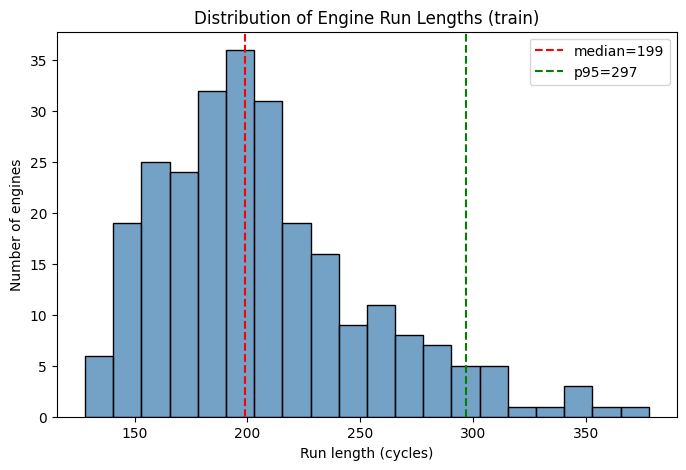

In [37]:
# --- 1. Histogram of engine run lengths ---
plt.figure(figsize=(8,5))
sns.histplot(length_per_engine.values, bins=20, kde=False, color="steelblue")
plt.axvline(length_per_engine.median(), color="red", linestyle="--", label=f"median={med_len:.0f}")
plt.axvline(np.percentile(length_per_engine.values, 95), color="green", linestyle="--", label=f"p95={p95_len:.0f}")
plt.title("Distribution of Engine Run Lengths (train)")
plt.xlabel("Run length (cycles)")
plt.ylabel("Number of engines")
plt.legend()
plt.show()

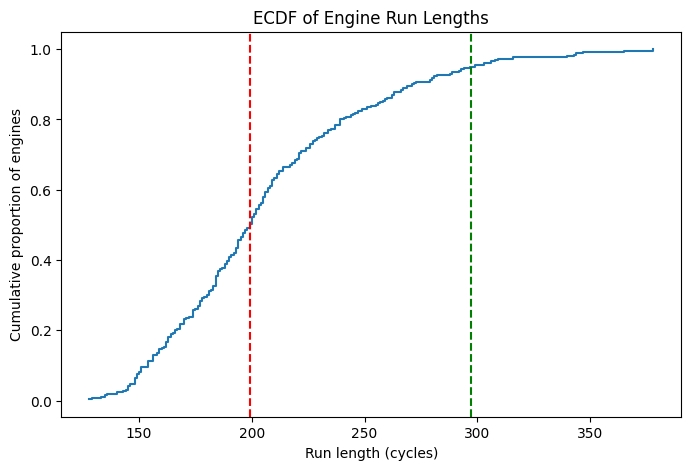

In [38]:
# --- 2. ECDF (empirical cumulative distribution) of run lengths ---
plt.figure(figsize=(8,5))
sorted_lengths = np.sort(length_per_engine.values)
ecdf = np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)
plt.step(sorted_lengths, ecdf, where="post")
plt.title("ECDF of Engine Run Lengths")
plt.xlabel("Run length (cycles)")
plt.ylabel("Cumulative proportion of engines")
plt.axvline(length_per_engine.median(), color="red", linestyle="--")
plt.axvline(np.percentile(length_per_engine.values, 95), color="green", linestyle="--")
plt.show()

shows what % of engines finish by a certain cycle.

In [39]:
# --- RUL range & quick summary ---
rul_min = int(train['RUL'].min())
rul_max = int(train['RUL'].max())

rul_desc = train['RUL'].describe(percentiles=[0.5, 0.9, 0.95]).round(2)

print("RUL range (train rows)")
print(f"  min: {rul_min}  |  max: {rul_max}")
print("\nRUL summary:")
print(rul_desc)

rul_p90 = float(np.percentile(train['RUL'].values, 90))
rul_p95 = float(np.percentile(train['RUL'].values, 95))
print(f"\nSuggested RUL clip candidates — p90: {rul_p90:.1f}, p95: {rul_p95:.1f}")

RUL range (train rows)
  min: 0  |  max: 377

RUL summary:
count    53759.00
mean       108.15
std         69.18
min          0.00
50%        103.00
90%        200.00
95%        230.00
max        377.00
Name: RUL, dtype: float64

Suggested RUL clip candidates — p90: 200.0, p95: 230.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


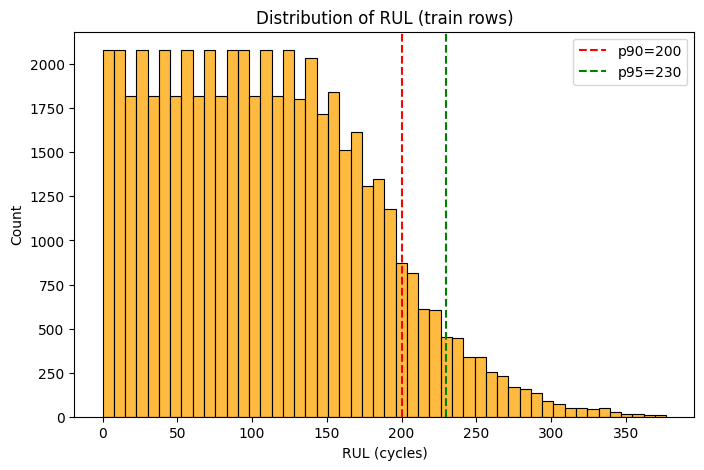

In [40]:
# --- 3. Histogram of RUL values (all train rows) ---
plt.figure(figsize=(8,5))
sns.histplot(train['RUL'], bins=50, kde=False, color="orange")
plt.axvline(rul_p90, color="red", linestyle="--", label=f"p90={rul_p90:.0f}")
plt.axvline(rul_p95, color="green", linestyle="--", label=f"p95={rul_p95:.0f}")
plt.title("Distribution of RUL (train rows)")
plt.xlabel("RUL (cycles)")
plt.ylabel("Count")
plt.legend()
plt.show()

- big spike at low RUL (near 0) (all engines eventually die).
- Also lots of rows with high RUL (early life).

This explains why we might need clipping or oversampling late-life windows

In [41]:
# --- Quartile-based grouping ---
q1 = float(np.percentile(length_per_engine.values, 25))
q3 = float(np.percentile(length_per_engine.values, 75))

def length_group(L):
    if L <= q1: return 'short'
    if L >= q3: return 'long'
    return 'medium'

length_groups = length_per_engine.to_frame().assign(group=lambda df: df['run_length'].apply(length_group))

counts = length_groups['group'].value_counts().reindex(['short','medium','long']).fillna(0).astype(int)
fracs  = (counts / counts.sum() * 100).round(1)

print("Engine length groups (quartile-based):")
print("Counts:\n", counts.to_string())
print("\nFractions (%):\n", fracs.to_string())

print(f"\nQuartile thresholds — Q1: {q1:.1f}, Q3: {q3:.1f}")


Engine length groups (quartile-based):
Counts:
 group
short      67
medium    128
long       65

Fractions (%):
 group
short     25.8
medium    49.2
long      25.0

Quartile thresholds — Q1: 174.0, Q3: 230.2


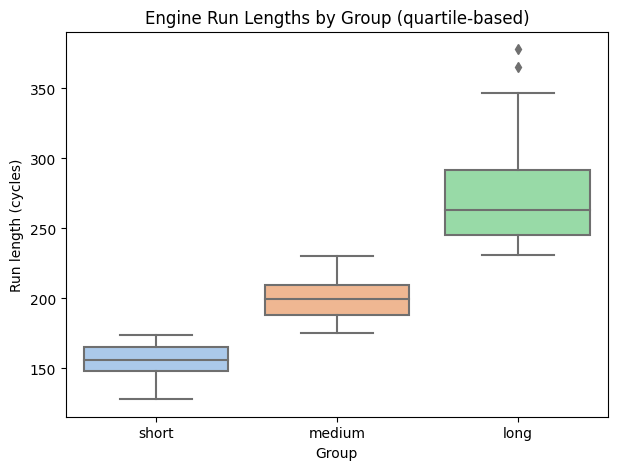

In [42]:
# --- 4. Boxplot of engine run lengths by group (short/medium/long) ---
plt.figure(figsize=(7,5))
sns.boxplot(data=length_groups, x="group", y="run_length", palette="pastel", order=["short","medium","long"])
plt.title("Engine Run Lengths by Group (quartile-based)")
plt.xlabel("Group")
plt.ylabel("Run length (cycles)")
plt.show()

Gives intuition about variability in each category.

In [43]:
assert train.groupby('unit_nr')['RUL'].min().eq(0).all(), "Every engine's last cycle should have RUL=0."
assert length_per_engine.shape[0] == n_train_engines, "Run-length table should match #train engines."

### First Thought given the results

- Window length W: since the shortest engine is 128 cycles, we should not pick too large. Safe starting point = 50 cycles (fits into all engines and leaves enough windows per engine). Later, we can try 100 cycles to see if long engines help.

- RUL clipping Rmax: data suggests 90% of RUL ≤ 200, 95% ≤ 230.

    - Clip at 125 or 140 → focuses on late life.

    - clip at 200 → keeps more range but may add noise.
 
- Sampling policy: since medium engines dominate, sampling by engine is important. oversampling late-life windows (low RUL) will help balance the signal.

# Settings Regimes



each row has three values: setting_1, setting_2, setting_3.

- these are operating conditions: they are like knobs that change how the engine is run (altitude, throttle, environment… the simulator doesn’t name them).

- they are not degradation signals by themselves, but they shift sensor readings.

example: the same healthy engine might show different sensor values if run in setting A vs setting B.

In [44]:
# --- 1. Round settings to nearest integer ---
train_settings_int = train[['setting_1','setting_2','setting_3']].round(0).astype(int)

# --- 2. Unique combinations ---
unique_combos = train_settings_int.value_counts().reset_index(name='count')

print(f"Unique integer setting combinations in TRAIN: {len(unique_combos)}")
print(unique_combos.head(10))  # show top 10 most frequent


Unique integer setting combinations in TRAIN: 6
   setting_1  setting_2  setting_3  count
0         42          1        100  13458
1         20          1        100   8122
2         10          0        100   8096
3          0          0        100   8044
4         35          1        100   8037
5         25          1         60   8002


checking distribution I noticied peaks on certain value, we found out that:

> The “continuous” settings were actually hiding a small finite set of operating conditions
> 
There are 6 unique operating regimes in the train set

In [46]:
# build regime IDs from rounded settings
train_keys = list(map(tuple, train_settings_int.values))
test_keys  = list(map(tuple, test_settings_int.values))

unique_train_combos = pd.Series(train_keys).unique().tolist()
regime_map = {combo: i for i, combo in enumerate(unique_train_combos)}  # e.g., 0..5
train['regime_id'] = [regime_map[k] for k in train_keys]
test['regime_id']  = [regime_map.get(k, -1) for k in test_keys]

print("Train regimes:", pd.Series(train['regime_id']).value_counts().sort_index())
print("Test regimes :", pd.Series(test['regime_id']).value_counts().sort_index())

Train regimes: regime_id
0     8037
1    13458
2     8002
3     8122
4     8044
5     8096
Name: count, dtype: int64
Test regimes : regime_id
0    5148
1    8483
2    5042
3    5063
4    5148
5    5107
Name: count, dtype: int64


In [47]:
regime_dummies_train = pd.get_dummies(train['regime_id'], prefix='regime', dtype=int)
regime_dummies_test = pd.get_dummies(test['regime_id'],  prefix='regime', dtype=int)

missing_in_test  = set(regime_dummies_train.columns) - set(regime_dummies_test.columns)
missing_in_train = set(regime_dummies_test.columns)  - set(regime_dummies_train.columns)

for c in missing_in_test:
    regime_dummies_test[c] = 0
for c in missing_in_train:
    regime_dummies_train[c] = 0

regime_dummies_train = regime_dummies_train.sort_index(axis=1)
regime_dummies_test  = regime_dummies_test.sort_index(axis=1)

train = pd.concat([train, regime_dummies_train], axis=1)
test  = pd.concat([test,  regime_dummies_test],  axis=1)
train = train.drop(columns=['regime_id'])
test = test.drop(columns=['regime_id'])

print("Regime one-hot columns:", [c for c in train.columns if c.startswith('regime_')])


Regime one-hot columns: ['regime_0', 'regime_1', 'regime_2', 'regime_3', 'regime_4', 'regime_5']


?? per-regime normalization of sensors (fit on train only)
to see again

# Focus on Sensors

We have to figure out which sensors behave like health indicators of wear so they’re useful for RUL prediction.

### Monotonicity vs wear (per engine × sensor): Kendall’s τ vs RUL (+ p-values)

As an engine wears out, RUL goes down. For a “good” health sensor, its reading should move consistently as RUL decreases (not necessarily linearly).
So we check, per engine and per sensor, whether the sensor shows a monotonic trend with RUL.

Why Kendall’s τ?

- It measures monotonic association (rank-based), not just linear.

- It’s robust to outliers and scaling.

- Sign tells us direction:

    - τ < 0 → sensor increases as RUL decreases (classic degradation pattern).

    - τ > 0 → sensor decreases as RUL decreases.

- Magnitude |τ| tells how consistent the trend is. A p-value adds statistical support.

p-value tell us whether that τ is statistically credible, not just noise

Why Kendall’s τ (not just correlation):

- It checks monotonic association (rank-based), not only linear.

- It’s robust to outliers and scaling.

- We don’t assume any particular shape—just “keeps going the same way.”

In [49]:
from scipy.stats import kendalltau

UNIT_COL, TIME_COL, RUL_COL = "unit_nr", "time_cycles", "RUL"
SENSOR_COLS = [c for c in train.columns if c.startswith("s_")]
TAU_MIN = 0.30    # threshold for “meaningful” |tau|
ALPHA = 0.05      # p-value threshold

# 1) ensure RUL exists
if RUL_COL not in train.columns:
    max_cycle = train.groupby(UNIT_COL)[TIME_COL].max()
    train = train.merge(max_cycle.to_frame("max_cycle"), left_on=UNIT_COL, right_index=True)
    train[RUL_COL] = train["max_cycle"] - train[TIME_COL]
    train.drop(columns="max_cycle", inplace=True)

# 2) per (engine, sensor) Kendall’s tau vs RUL
rows = []
for unit, g in train.groupby(UNIT_COL, sort=True):
    g = g.sort_values(TIME_COL)
    y = g[RUL_COL].to_numpy()
    for s in SENSOR_COLS:
        x = g[s].to_numpy()
        if np.sum(~np.isnan(x)) < 5 or np.nanstd(x) == 0:
            tau, p = np.nan, np.nan
        else:
            tau, p = kendalltau(x, y, nan_policy='omit')
        rows.append((unit, s, tau, p, len(g)))

engine_sensor_tau = pd.DataFrame(rows, columns=[UNIT_COL, "sensor", "tau", "pvalue", "n_points"])

# 3) per-sensor summary across engines
def _summ(g):
    valid = g["tau"].dropna()
    if valid.empty:
        return pd.Series({
            "n_engines": g[UNIT_COL].nunique(),
            "frac_strong_sig": np.nan,
            "median_tau": np.nan,
            "median_abs_tau": np.nan,
            "frac_negative": np.nan
        })
    strong_sig = g[(g["tau"].abs() >= TAU_MIN) & (g["pvalue"] < ALPHA)]
    return pd.Series({
        "n_engines": g[UNIT_COL].nunique(),
        "frac_strong_sig": len(strong_sig) / g[UNIT_COL].nunique(),
        "median_tau": valid.median(),
        "median_abs_tau": valid.abs().median(),
        "frac_negative": (g["tau"] < 0).mean()
    })

sensor_monotonicity = engine_sensor_tau.groupby("sensor").apply(_summ).reset_index()
sensor_monotonicity["rank_key"] = (
    sensor_monotonicity["frac_strong_sig"].fillna(0) * 0.7 +
    sensor_monotonicity["median_abs_tau"].fillna(0) * 0.3
)
sensor_monotonicity = sensor_monotonicity.sort_values("rank_key", ascending=False)

/tmp/ipykernel_36/3121725568.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sensor_monotonicity = engine_sensor_tau.groupby("sensor").apply(_summ).reset_index()


In [50]:
engine_sensor_tau.head()

,unit_nr,sensor,tau,pvalue,n_points
0,1,s_1,-0.070707,0.236898,149
1,1,s_2,-0.154419,0.005239,149
2,1,s_3,-0.177679,0.001303,149
3,1,s_4,-0.197814,0.000344,149
4,1,s_5,-0.068304,0.253218,149


one row per (engine, sensor) with τ and p-value

Interpretation of table above: s_2, s_3, s_4 are monotone with wear in this engine.

In [51]:
sensor_monotonicity

,sensor,n_engines,frac_strong_sig,median_tau,median_abs_tau,frac_negative,rank_key
4,s_13,260.0,0.373077,-0.222726,0.225582,0.826923,0.328828
5,s_14,260.0,0.084615,-0.078563,0.140519,0.596154,0.101386
2,s_11,260.0,0.000000,-0.136665,0.136665,1.000000,0.040999
15,s_4,260.0,0.000000,-0.130398,0.130398,1.000000,0.039119
6,s_15,260.0,0.000000,-0.119023,0.119023,0.992308,0.035707
20,s_9,260.0,0.000000,-0.072931,0.098327,0.719231,0.029498
8,s_17,260.0,0.000000,-0.087503,0.087503,0.961538,0.026251
14,s_3,260.0,0.000000,-0.084319,0.084319,0.961538,0.025296
19,s_8,260.0,0.000000,-0.063187,0.083148,0.719231,0.024945
11,s_2,260.0,0.000000,-0.077916,0.078427,0.950000,0.023528


one row per sensor with:

- frac_strong_sig: fraction of engines where that sensor shows a clear, significant monotonic trend with wear.

- median_tau and median_abs_tau: typical direction and strength.

- frac_negative: how often the trend is the classic “sensor ↑ as RUL ↓”.

Sensors with high frac_strong_sig and decent median_abs_tau are reliably wear-sensitive, which makes them strong RUL features

- s_13 stands out (highest frac_strong_sig and decent median_abs_tau).

- s_14 shows up sometimes, but weaker.

- Many others are near zero → not useful for RUL.

In [52]:
def plot_tau_hist(engine_sensor_tau_df, sensor, bins=20):
    vals = (engine_sensor_tau_df[engine_sensor_tau_df["sensor"]==sensor]
            ["tau"].dropna().to_numpy())
    if vals.size == 0:
        print(f"No tau values for {sensor}")
        return
    plt.figure(figsize=(7,4))
    plt.hist(vals, bins=bins, edgecolor="black", alpha=0.8)
    plt.axvline(0, lw=1.5, ls="--")
    plt.xlabel("Kendall's tau (sensor vs RUL)")
    plt.ylabel("count")
    plt.title(f"Monotonicity (τ) distribution — {sensor}")
    plt.tight_layout()
    plt.show()

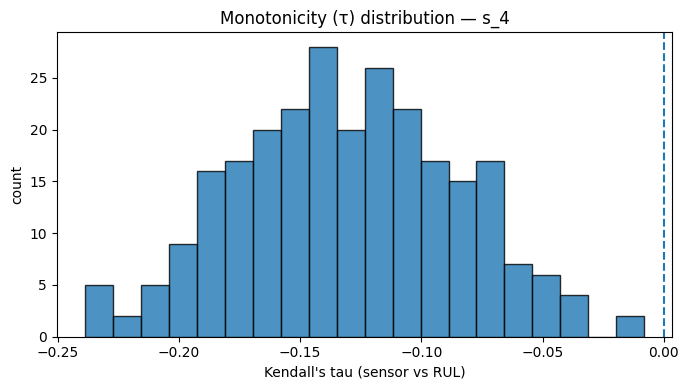

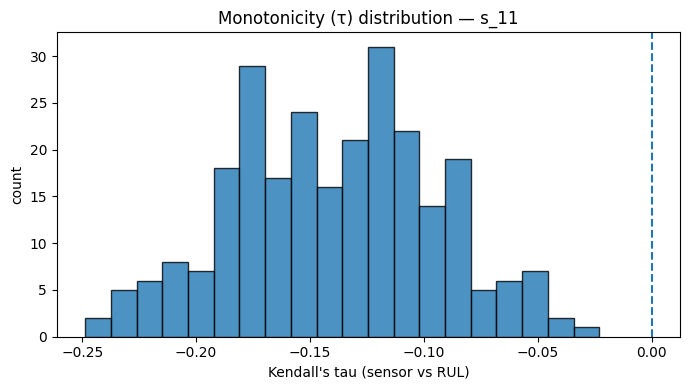

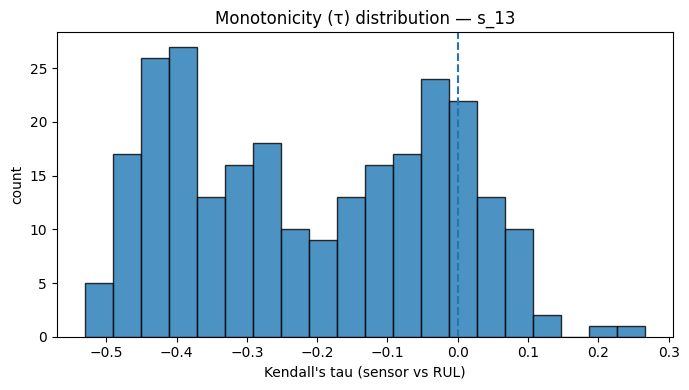

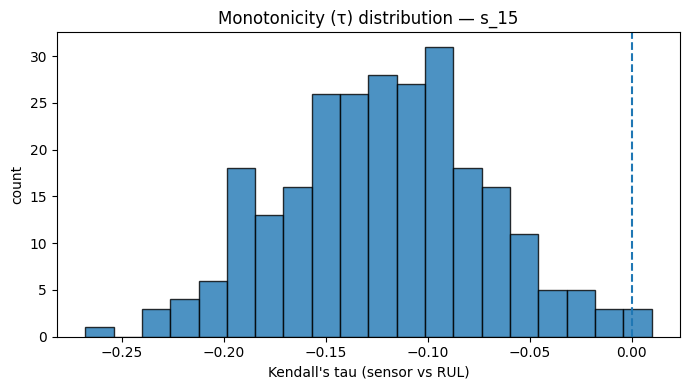

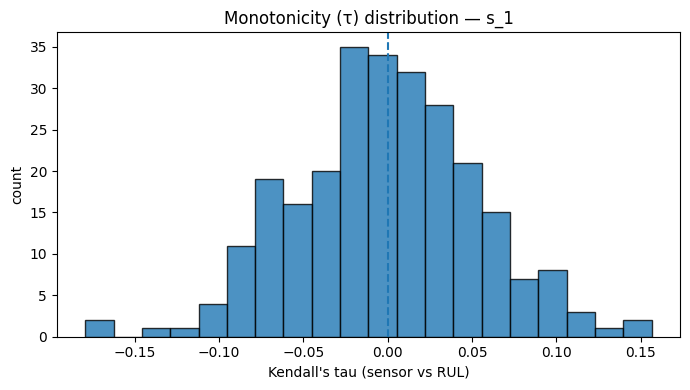

In [53]:
plot_tau_hist(engine_sensor_tau, "s_4")
plot_tau_hist(engine_sensor_tau, "s_11")
plot_tau_hist(engine_sensor_tau, "s_13")
plot_tau_hist(engine_sensor_tau, "s_15")
plot_tau_hist(engine_sensor_tau, "s_1") # example of not significative

In τ hist, a healthy sensor’s τ should skew negative (if it increases as RUL drops) or positive consistently.

Limitations to remember:
- Operating settings/regimes can hide real trends. We simplified settings so we can stratify by regime later if needed.)
- Some useful sensors aren’t monotone early on—that’s where onset helps.

### Degradation on set

> The goal is to find the cycle where degradation begins and measure the post-onset slope.

What “onset” means here:

1. Early life: variations mostly due to noise/conditions.

2. At some point, the signal starts to trend consistently (up or down) → degradation phase.

3. We want that switch point per engine × sensor.

In [54]:

from scipy.stats import theilslopes, kendalltau

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs): 
        return x  # fallback: no progress ba

# ---------------- SPEED/WEIGHT CONFIG ----------------
UNIT_COL, TIME_COL = "unit_nr", "time_cycles"
ALL_SENSORS = [c for c in train.columns if c.startswith("s_")]

# Limit scope for quick runs (set to None to use all)
ENGINE_LIMIT   = None         
SENSOR_LIMIT   = None    
SENSOR_COLS    = ALL_SENSORS[:SENSOR_LIMIT] if SENSOR_LIMIT else ALL_SENSORS

# Make the scan lighter:
SMOOTH_WIN       = 3           
MIN_SEG_LEN      = 10        
IGNORE_FIRST_FRAC= 0.10      
CANDIDATE_STRIDE = 2          
SLOPE_MIN        = 0.002      
TAU_POST_MIN     = 0.20       

# ---------------- Helpers ----------------
def robust_rollmed(x, win):
    if win is None or win <= 1:
        return np.asarray(x, dtype="float64")
    s = pd.Series(x, dtype="float64")
    return s.rolling(win, center=True, min_periods=1).median().to_numpy()

def robust_zscore(x):
    x = np.asarray(x, dtype="float64")
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    scale = 1.4826 * mad if mad > 0 else (np.nanstd(x) or 1.0)
    return (x - med) / (scale if scale != 0 else 1.0)

def detect_onset_light(x,
                       smooth_win=SMOOTH_WIN,
                       min_seg_len=MIN_SEG_LEN,
                       ignore_first_frac=IGNORE_FIRST_FRAC,
                       candidate_stride=CANDIDATE_STRIDE,
                       slope_min=SLOPE_MIN,
                       tau_post_min=TAU_POST_MIN):
    """
    Lightweight 1-break onset detector:
      - smooth + robust-scale
      - scan candidate splits with a stride
      - earliest c where |Theil–Sen slope(post)| >= slope_min AND |Kendall τ(post vs time)| >= tau_post_min
    Returns: (onset_index or None, post_onset_slope or None)
    """
    x = np.asarray(x, dtype="float64")
    if np.sum(~np.isnan(x)) < (min_seg_len * 2) or np.nanstd(x) == 0:
        return None, None

    xs = robust_zscore(robust_rollmed(x, smooth_win))
    n = len(xs)
    start_idx = int(np.floor(ignore_first_frac * n))
    start_idx = max(start_idx, min_seg_len)     # ensure enough pre points
    end_max = n - min_seg_len                   # ensure enough post points
    if start_idx >= end_max:
        return None, None

    # stride over candidates to reduce checks
    for c in range(start_idx, end_max, candidate_stride):
        post = xs[c:]
        idx = np.arange(len(post))
        slope, intercept, _, _ = theilslopes(post, idx, 0.95)
        if not np.isfinite(slope) or abs(slope) < slope_min:
            continue
        tau, _ = kendalltau(post, idx, nan_policy="omit")
        if tau is None or np.isnan(tau) or abs(tau) < tau_post_min:
            continue
        return c, float(slope)

    return None, None

# ---------------- Apply per engine × sensor with progress bar ----------------
def run_onset_detection_light(df, sensors=SENSOR_COLS, unit_col=UNIT_COL, time_col=TIME_COL, engine_limit=ENGINE_LIMIT):
    rows = []
    # Order engines and optionally cap count
    units = sorted(df[unit_col].unique())
    if engine_limit is not None:
        units = units[:engine_limit]

    for unit in tqdm(units, desc="Engines", leave=False):
        g = df[df[unit_col] == unit].sort_values(time_col)
        t = g[time_col].to_numpy()
        n = len(g)

        # Pre-cache series to avoid repeated lookups
        series_cache = {s: g[s].to_numpy() for s in sensors}

        for s in sensors:
            x = series_cache[s]
            onset_idx, post_slope = detect_onset_light(x)
            if onset_idx is None:
                rows.append((unit, s, None, None, None, None))
            else:
                onset_cycle = int(t[onset_idx])
                onset_frac = onset_idx / max(1, n - 1)
                rows.append((unit, s, onset_idx, onset_cycle, onset_frac, post_slope))

    cols = [unit_col, "sensor", "onset_idx", "onset_cycle", "onset_frac_of_life", "post_onset_slope"]
    return pd.DataFrame(rows, columns=cols)

onsets = run_onset_detection_light(train)

# ---------------- Per-sensor summary ----------------
def summarize_onsets(onsets_df):
    def _summ(g):
        valid = g.dropna(subset=["onset_frac_of_life"])
        if valid.empty:
            return pd.Series({
                "coverage": 0.0,
                "median_onset_frac": np.nan,
                "iqr_onset_frac": np.nan,
                "median_post_slope": np.nan,
                "iqr_post_slope": np.nan
            })
        q1, q3 = valid["onset_frac_of_life"].quantile([0.25, 0.75]).values
        p1, p3 = valid["post_onset_slope"].quantile([0.25, 0.75]).values
        return pd.Series({
            "coverage": len(valid) / g["unit_nr"].nunique(),
            "median_onset_frac": valid["onset_frac_of_life"].median(),
            "iqr_onset_frac": q3 - q1,
            "median_post_slope": valid["post_onset_slope"].median(),
            "iqr_post_slope": p3 - p1
        })
    return onsets_df.groupby("sensor").apply(_summ).reset_index()

onset_summary = summarize_onsets(onsets)

Engines:   0%|          | 0/260 [00:00<?, ?it/s]

/tmp/ipykernel_36/642269753.py:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return onsets_df.groupby("sensor").apply(_summ).reset_index()


In [55]:
onsets.head()

,unit_nr,sensor,onset_idx,onset_cycle,onset_frac_of_life,post_onset_slope
0,1,s_1,138.0,139.0,0.932432,0.083959
1,1,s_2,36.0,37.0,0.243243,0.002246
2,1,s_3,36.0,37.0,0.243243,0.008640
3,1,s_4,34.0,35.0,0.229730,0.009329
4,1,s_5,74.0,75.0,0.500000,0.007300


We now have a temporal marker of when degradation starts per engine and sensor.

For each (engine, sensor), the detector found:

- onset_idx / onset_cycle: when degradation seems to begin.

- onset_frac_of_life: normalized [0–1].

In [56]:
def plot_engine_sensor_with_onset(train_df, onsets_df, unit, sensor, smooth_win=5):
    g = (train_df[train_df[UNIT_COL]==unit]
         .sort_values(TIME_COL)
         .reset_index(drop=True))
    if g.empty:
        print(f"No data for unit {unit}")
        return

    # series
    t  = g[TIME_COL].to_numpy()
    x  = g[sensor].to_numpy()
    xs = robust_rollmed(x, smooth_win)

    # onset row
    row = onsets_df[(onsets_df[UNIT_COL]==unit) & (onsets_df["sensor"]==sensor)]
    onset_idx = None if row.empty else (None if pd.isna(row["onset_idx"].values[0]) else int(row["onset_idx"].values[0]))

    plt.figure(figsize=(9,4.5))
    plt.plot(t, x, lw=1, alpha=0.35, label="raw")
    plt.plot(t, xs, lw=2, label=f"smoothed (win={smooth_win})")

    if onset_idx is not None:
        onset_cycle = int(row["onset_cycle"].values[0])
        slope = row["post_onset_slope"].values[0]
        plt.axvline(onset_cycle, ls="--", lw=2, label=f"onset @ {onset_cycle}")
        # shade pre/post
        plt.axvspan(t[0], onset_cycle, alpha=0.06)
        plt.axvspan(onset_cycle, t[-1], alpha=0.10)
        plt.title(f"{sensor} — unit {unit} | onset={onset_cycle}, post-slope={slope:.4f}")
    else:
        plt.title(f"{sensor} — unit {unit} | onset: not detected")

    plt.xlabel("cycle")
    plt.ylabel(sensor)
    plt.legend()
    plt.tight_layout()
    plt.show()


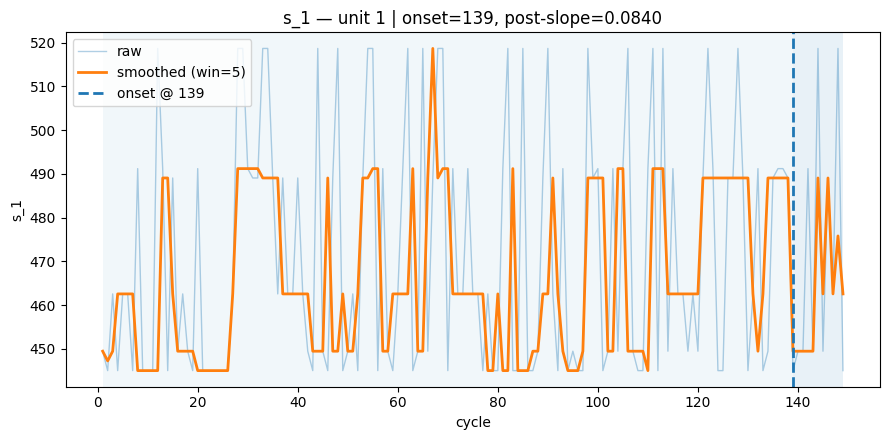

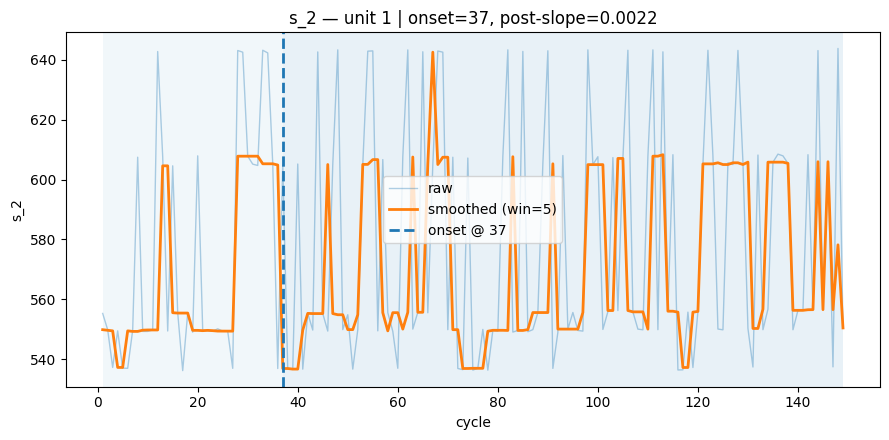

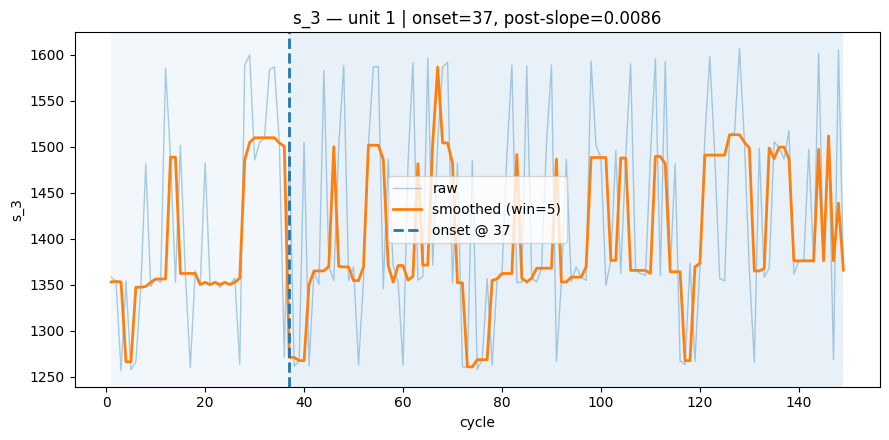

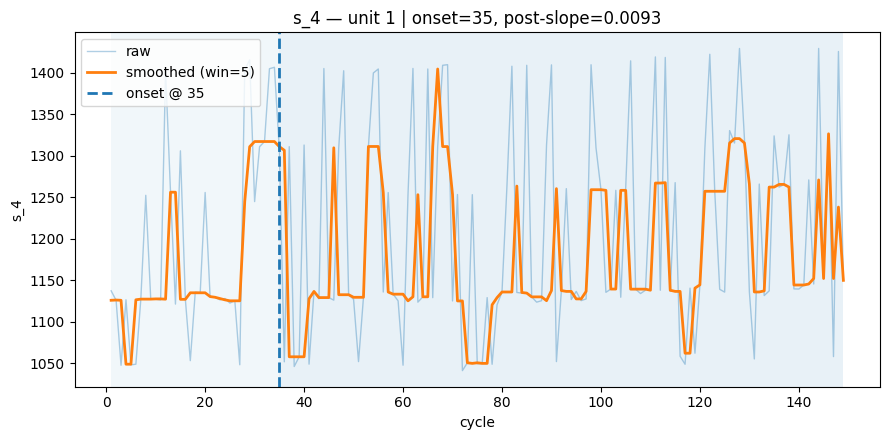

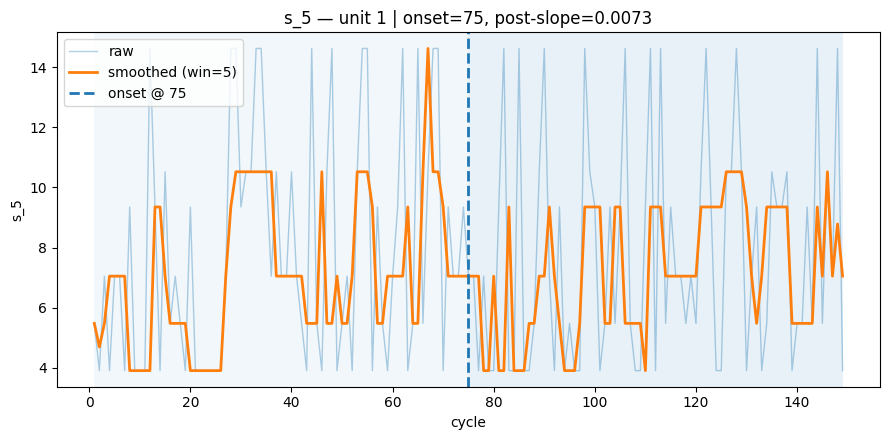

In [57]:
plot_engine_sensor_with_onset(train, onsets, unit=1, sensor="s_1", smooth_win=5)
plot_engine_sensor_with_onset(train, onsets, unit=1, sensor="s_2", smooth_win=5)
plot_engine_sensor_with_onset(train, onsets, unit=1, sensor="s_3", smooth_win=5)
plot_engine_sensor_with_onset(train, onsets, unit=1, sensor="s_4", smooth_win=5)
plot_engine_sensor_with_onset(train, onsets, unit=1, sensor="s_5", smooth_win=5)

In single-engine plots, onset (dashed line) should mark where the smoothed signal starts a clearer trend.

In [58]:
onset_summary.sort_values("coverage", ascending=False)

,sensor,coverage,median_onset_frac,iqr_onset_frac,median_post_slope,iqr_post_slope
2,s_11,1.000000,0.169355,0.345678,0.003933,0.003363
15,s_4,0.996154,0.317919,0.508889,0.003705,0.003344
20,s_9,0.992308,0.630093,0.499710,0.002902,0.007538
11,s_2,0.992308,0.759711,0.244090,0.002230,0.011374
5,s_14,0.992308,0.110959,0.475567,0.005106,0.015889
14,s_3,0.992308,0.655631,0.442523,0.004201,0.004819
13,s_21,0.992308,0.756991,0.218413,-0.002314,0.011224
8,s_17,0.988462,0.630208,0.436231,0.003854,0.004499
4,s_13,0.984615,0.099644,0.551661,0.012241,0.013144
0,s_1,0.980769,0.791111,0.208833,0.002007,0.008803


Each row = one sensor across all engines.

- coverage: fraction of engines where we could detect an onset.

- median_onset_frac: typical onset timing e.g., s_4 = 0.32 → degradation starts around 1/3 of life.

- median_post_slope: typical post-onset slope magnitude.

- s_11 and s_4 → consistently give early/mid-life onsets.

- s_19 is odd → onset very late (median 0.95) → less useful.

- Sensors with high coverage + early onset are the best health indicators.

In [59]:
def plot_onset_fraction_hist(onsets_df, sensor, bins=20):
    vals = (onsets_df[onsets_df["sensor"]==sensor]
            ["onset_frac_of_life"].dropna().to_numpy())
    if vals.size == 0:
        print(f"No onsets for {sensor}")
        return
    plt.figure(figsize=(7,4))
    plt.hist(vals, bins=bins, edgecolor="black", alpha=0.8)
    plt.xlabel("onset fraction of life (0=early, 1=late)")
    plt.ylabel("count")
    plt.title(f"Onset fraction distribution — {sensor}")
    plt.tight_layout()
    plt.show()


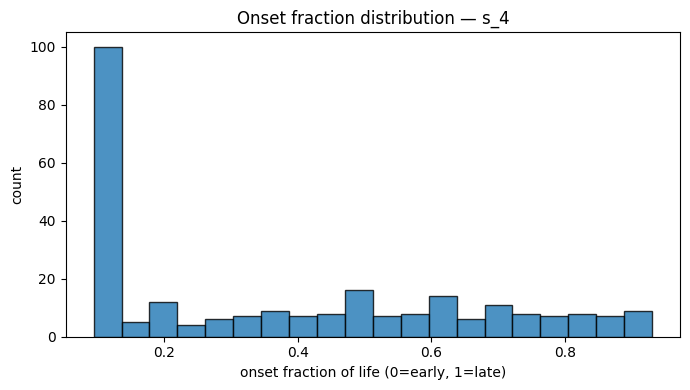

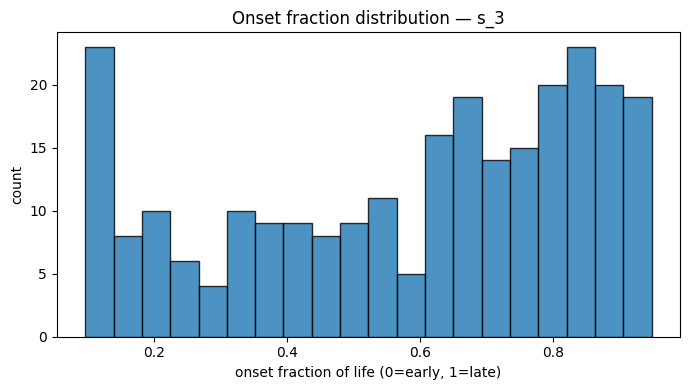

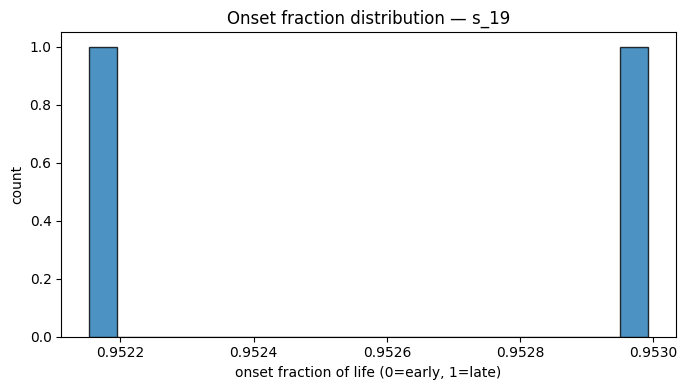

In [60]:
plot_onset_fraction_hist(onsets, "s_4")
plot_onset_fraction_hist(onsets, "s_3")
plot_onset_fraction_hist(onsets, "s_19")

In onset fraction hist, useful health sensors usually start not too late (peaks around 0.2–0.6).

## Turning what we learned into feature engineering

each feature tells us (in practice)

- unit_nr — engine id (join key).

- time_cycles — when we “took the snapshot” for this engine.

- RUL — label at the snapshot (target for training).

### Feature Selection

First of all we reduce the dimension of our dataset, we want to take two method into consideration even though quite similar to obtain a less biased outcome 

#### Unsupervised threshold (onset quality only)

In [61]:
import numpy as np
import pandas as pd

# ---- helpers ----
def _mm01(s: pd.Series):
    s = s.astype(float)
    lo, hi = np.nanmin(s.values), np.nanmax(s.values)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - lo) / (hi - lo)

# ---- config (simple & interpretable) ----
# coverage:   higher is better (already 0..1)
# onset_early = 1 - median_onset_frac  (earlier is better; clamp 0..1)
# slope_norm = min-max of |median_post_slope|
SCORE_MIN = 0.04   # <-- make this easier/harder to reach

ons = onset_summary.copy()

ons["coverage_f"]    = ons["coverage"].clip(0, 1).fillna(0)
ons["onset_early_f"] = (1 - ons["median_onset_frac"].clip(0, 1)).fillna(0)
ons["slope_norm_f"]  = _mm01(ons["median_post_slope"].abs().fillna(0))

# simple weighted sum (sums to 1)
w_cov, w_early, w_slope = 0.5, 0.35, 0.15
ons["score_unsup"] = (
    w_cov  * ons["coverage_f"] +
    w_early* ons["onset_early_f"] +
    w_slope* ons["slope_norm_f"]
)

# soft gates to avoid pathological picks (feel free to relax these)
GATE_MIN_COVERAGE = 0.50
GATE_MAX_ONSET_FRAC = 0.98

mask_gate  = (ons["coverage_f"] >= GATE_MIN_COVERAGE) & (ons["median_onset_frac"] <= GATE_MAX_ONSET_FRAC)
mask_score = ons["score_unsup"] >= SCORE_MIN

selected_unsup = (ons.loc[mask_gate & mask_score]
                    .sort_values("score_unsup", ascending=False)
                    [["sensor","score_unsup","coverage_f","onset_early_f","slope_norm_f"]])

SELECTED_SENSORS = selected_unsup["sensor"].tolist()
print(f" [A] Selected {len(SELECTED_SENSORS)} sensors with score >= {SCORE_MIN}")
display(selected_unsup)


 [A] Selected 19 sensors with score >= 0.04


,sensor,score_unsup,coverage_f,onset_early_f,slope_norm_f
4,s_13,0.811408,0.984615,0.900356,0.026505
5,s_14,0.808522,0.992308,0.889041,0.008025
2,s_11,0.791474,1.000000,0.830645,0.004988
6,s_15,0.760377,0.980769,0.765854,0.012959
15,s_4,0.737465,0.996154,0.682081,0.004398
20,s_9,0.625969,0.992308,0.369907,0.002317
8,s_17,0.624375,0.988462,0.369792,0.004784
14,s_3,0.617535,0.992308,0.344369,0.005681
13,s_21,0.581326,0.992308,0.243009,0.000796
11,s_2,0.580342,0.992308,0.240289,0.000578


#### Semi-supervised threshold (add monotonicity vs RUL)

In [62]:
m = (sensor_monotonicity.merge(onset_summary, on="sensor", how="inner")).copy()

# normalize monotonicity pieces
m["frac_strong_sig_f"] = m["frac_strong_sig"].clip(0,1).fillna(0)
m["tau_norm_f"]        = _mm01(m["median_abs_tau"].fillna(0))

# reuse onset pieces from above
m["coverage_f"]    = m["coverage"].clip(0,1).fillna(0)
m["onset_early_f"] = (1 - m["median_onset_frac"].clip(0,1)).fillna(0)
m["slope_norm_f"]  = _mm01(m["median_post_slope"].abs().fillna(0))

# weights sum to 1 (tilt toward onset quality, then monotonicity)
w_cov, w_early, w_slope, w_fracsig, w_tau = 0.35, 0.25, 0.10, 0.20, 0.10
m["score_combo"] = (
    w_cov     * m["coverage_f"] +
    w_early   * m["onset_early_f"] +
    w_slope   * m["slope_norm_f"] +
    w_fracsig * m["frac_strong_sig_f"] +
    w_tau     * m["tau_norm_f"]
)

SCORE_MIN = 0.3   # <-- one knob. lower = include more
GATE_MIN_COVERAGE = 0.45
GATE_MAX_ONSET_FRAC = 0.98

mask_gate  = (m["coverage_f"] >= GATE_MIN_COVERAGE) & (m["median_onset_frac"] <= GATE_MAX_ONSET_FRAC)
mask_score = m["score_combo"] >= SCORE_MIN

selected_combo = (m.loc[mask_gate & mask_score]
                    .sort_values("score_combo", ascending=False)
                    [["sensor","score_combo",
                      "coverage_f","onset_early_f","slope_norm_f",
                      "frac_strong_sig_f","tau_norm_f"]])

SELECTED_SENSORS = selected_combo["sensor"].tolist()
print(f"[B] Selected {len(SELECTED_SENSORS)} sensors with score >= {SCORE_MIN}")
display(selected_combo)


[B] Selected 18 sensors with score >= 0.3


,sensor,score_combo,coverage_f,onset_early_f,slope_norm_f,frac_strong_sig_f,tau_norm_f
0,s_13,0.746970,0.984615,0.900356,0.026505,0.373077,1.000000
1,s_14,0.643202,0.992308,0.889041,0.008025,0.084615,0.559087
2,s_11,0.612071,1.000000,0.830645,0.004988,0.000000,0.539112
4,s_15,0.580795,0.980769,0.765854,0.012959,0.000000,0.447667
3,s_4,0.570277,0.996154,0.682081,0.004398,0.000000,0.506630
5,s_9,0.474055,0.992308,0.369907,0.002317,0.000000,0.340391
6,s_17,0.467317,0.988462,0.369792,0.004784,0.000000,0.284288
7,s_3,0.460747,0.992308,0.344369,0.005681,0.000000,0.267787
9,s_2,0.431162,0.992308,0.240289,0.000578,0.000000,0.237245
13,s_21,0.421065,0.992308,0.243009,0.000796,0.000000,0.129252


In B we miss the s_10, in both s_16 and s_19 are missing

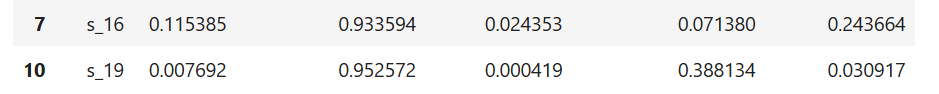

For every selected sensor s:

- s_sm (smoothed value): the denoised signal you’d actually feed a model.

- s_after_onset: “has degradation started yet?” Binary, very informative.

- s_time_since_onset: how long we’ve been degrading (longer ⇒ likely lower RUL).

- s_delta_from_onset: how far the sensor has moved since onset (magnitude of degradation in sensor units).

- s_post_slope: current trend speed after onset (steeper ⇒ faster degradation).

- s_onset_frac_prefix: whether the onset happened early or late in the observed life so far (context of the above features).

All of these are computed online on the prefix only (no look-ahead). At test time, you compute the same features on the last observed cycle and predict RUL.

In [63]:
import numpy as np
import pandas as pd

# ===== CONFIG =====
UNIT_COL, TIME_COL, RUL_COL = "unit_nr", "time_cycles", "RUL"

SNAPSHOT_MODE   = "quantile"   # "quantile" or "random"
SNAPSHOT_Q      = 0.7          # if quantile
SNAPSHOT_QMIN   = 0.45         # if random
SNAPSHOT_QMAX   = 0.85         # if random

# smoothing used for visual parity with previous steps
SMOOTH_WIN = 5
MIN_SEG_LEN = 10             
IGNORE_FIRST_FRAC = 0.10
CANDIDATE_STRIDE = 2
SLOPE_MIN = 0.002
TAU_POST_MIN = 0.20

In [64]:
from scipy.stats import theilslopes, kendalltau

def robust_rollmed(x, win):
    s = pd.Series(x, dtype="float64")
    return s.rolling(win, center=True, min_periods=1).median().to_numpy()

def robust_zscore(x):
    x = np.asarray(x, dtype="float64")
    med = np.nanmedian(x); mad = np.nanmedian(np.abs(x - med))
    scale = 1.4826*mad if mad>0 else (np.nanstd(x) or 1.0)
    return (x - med) / (scale if scale!=0 else 1.0)

def detect_onset_light_prefix(x,
                              smooth_win=SMOOTH_WIN,
                              min_seg_len=MIN_SEG_LEN,
                              ignore_first_frac=IGNORE_FIRST_FRAC,
                              candidate_stride=CANDIDATE_STRIDE,
                              slope_min=SLOPE_MIN,
                              tau_post_min=TAU_POST_MIN):
    """
    SAME detector as before but you pass ONLY the prefix x[:t+1].
    Returns (onset_idx or None, post_onset_slope or None) computed within the PREFIX.
    """
    x = np.asarray(x, dtype="float64")
    if np.sum(~np.isnan(x)) < (min_seg_len*2) or np.nanstd(x)==0:
        return None, None

    xs = robust_zscore(robust_rollmed(x, smooth_win))
    n = len(xs)
    start_idx = max(int(np.floor(ignore_first_frac*n)), min_seg_len)
    end_max   = n - min_seg_len
    if start_idx >= end_max:
        return None, None

    for c in range(start_idx, end_max, candidate_stride):
        post = xs[c:]
        idx  = np.arange(len(post))
        slope, _, _, _ = theilslopes(post, idx, 0.95)
        if not np.isfinite(slope) or abs(slope) < slope_min: 
            continue
        tau, _ = kendalltau(post, idx, nan_policy="omit")
        if tau is None or np.isnan(tau) or abs(tau) < tau_post_min:
            continue
        return c, float(slope)

    return None, None

In [65]:
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs): 
        return x

def choose_snapshot_index(times: np.ndarray, mode=SNAPSHOT_MODE, q=SNAPSHOT_Q, qmin=SNAPSHOT_QMIN, qmax=SNAPSHOT_QMAX):
    n = len(times)
    if n == 0: 
        return None
    if mode == "quantile":
        cut_cycle = np.quantile(times, q)
    else:
        frac = np.random.uniform(qmin, qmax)
        cut_cycle = np.quantile(times, frac)
    # nearest index
    return int(np.argmin(np.abs(times - cut_cycle)))

def features_at_snapshot_prefix(g_unit: pd.DataFrame, sensors, snap_idx: int):
    """
    g_unit: rows of a single engine sorted by time
    snap_idx: index in this engine's dataframe representing the snapshot row
    Returns: dict of features for that engine at the snapshot
    """
    out = {
        UNIT_COL: int(g_unit[UNIT_COL].iloc[0]),
        TIME_COL: int(g_unit[TIME_COL].iloc[snap_idx]),
        RUL_COL:  int(g_unit["RUL"].iloc[snap_idx]) if "RUL" in g_unit.columns else None
    }

    # cache time and each sensor prefix
    t_all = g_unit[TIME_COL].to_numpy()
    for s in sensors:
        x_all = g_unit[s].to_numpy()
        x_pref = x_all[:snap_idx+1]

        # smoothed current value at snapshot
        xs_pref = robust_rollmed(x_pref, SMOOTH_WIN)
        sm_now = xs_pref[-1]

        # online onset on the prefix
        onset_idx, post_slope = detect_onset_light_prefix(x_pref)

        # derived feat at snapshot
        if onset_idx is None:
            after_onset = 0.0
            time_since  = 0.0
            val_at_onset= np.nan
            delta_from  = np.nan
            onset_frac_prefix = np.nan
        else:
            after_onset = 1.0
            time_since  = (snap_idx - onset_idx)
            val_at_onset= xs_pref[onset_idx]
            delta_from  = sm_now - val_at_onset
            onset_frac_prefix = onset_idx / max(1, snap_idx)  # fraction within observed prefix

        out.update({
            f"{s}_sm": sm_now,
            f"{s}_after_onset": after_onset,
            f"{s}_time_since_onset": float(time_since),
            f"{s}_delta_from_onset": float(delta_from) if np.isfinite(delta_from) else np.nan,
            f"{s}_post_slope": float(post_slope) if post_slope is not None else np.nan,
            f"{s}_onset_frac_prefix": float(onset_frac_prefix)
        })

    return out

def build_last_snapshot_dataset(train_df: pd.DataFrame, sensors):
    rows = []
    for unit, g in tqdm(train_df.groupby(UNIT_COL, sort=True), desc="Building one-snapshot dataset"):
        g = g.sort_values(TIME_COL).reset_index(drop=True)
        times = g[TIME_COL].to_numpy()
        snap_idx = choose_snapshot_index(times)
        if snap_idx is None:
            continue
        rows.append(features_at_snapshot_prefix(g, sensors, snap_idx))
    df = pd.DataFrame(rows).sort_values(UNIT_COL).reset_index(drop=True)
    return df

train_one_snapshot = build_last_snapshot_dataset(train, SELECTED_SENSORS)

print(train_one_snapshot.shape)

Building one-snapshot dataset:   0%|          | 0/260 [00:00<?, ?it/s]

(260, 111)


In [66]:
train_one_snapshot.head()

,unit_nr,time_cycles,RUL,s_13_sm,s_13_after_onset,s_13_time_since_onset,s_13_delta_from_onset,s_13_post_slope,s_13_onset_frac_prefix,s_14_sm,...,s_8_time_since_onset,s_8_delta_from_onset,s_8_post_slope,s_8_onset_frac_prefix,s_18_sm,s_18_after_onset,s_18_time_since_onset,s_18_delta_from_onset,s_18_post_slope,s_18_onset_frac_prefix
0,1,105,44,2388.10,1.0,40.0,0.31,0.046371,0.615385,8045.91,...,38.0,-64.17,0.027126,0.634615,2324.0,1.0,38.0,-64.0,0.026980,0.634615
1,2,189,80,2388.22,1.0,170.0,0.11,0.010840,0.095745,8074.55,...,24.0,0.03,0.056182,0.872340,2324.0,1.0,24.0,0.0,0.056208,0.872340
2,3,144,62,2388.14,1.0,129.0,0.12,0.013225,0.097902,8066.79,...,15.0,95.98,-0.015993,0.895105,2319.0,1.0,15.0,96.0,-0.016181,0.895105
3,4,165,70,2388.41,1.0,148.0,0.39,0.034997,0.097561,8086.81,...,26.0,11.17,0.002426,0.841463,2223.0,1.0,12.0,11.0,-0.075880,0.926829
4,5,108,46,2388.34,1.0,97.0,0.36,0.026980,0.093458,8104.39,...,35.0,-106.56,-0.026071,0.672897,2212.0,1.0,35.0,-107.0,-0.026264,0.672897


In [67]:
# make test the same way

def build_test_last_snapshot(test_df: pd.DataFrame, sensors):
    # here the "snapshot" is simply the last observed row in test for each engine
    rows = []
    for unit, g in tqdm(test_df.groupby(UNIT_COL, sort=True), desc="Test features"):
        g = g.sort_values(TIME_COL).reset_index(drop=True)
        snap_idx = len(g)-1
        rows.append(features_at_snapshot_prefix(g, sensors, snap_idx))
    df = pd.DataFrame(rows).sort_values(UNIT_COL).reset_index(drop=True)
    # drop target if present (no labels in test)
    if RUL_COL in df.columns:
        df = df.drop(columns=[RUL_COL])
    return df

test_one_snapshot = build_test_last_snapshot(test, SELECTED_SENSORS)


Test features:   0%|          | 0/259 [00:00<?, ?it/s]

In [68]:
# ----- CONFIG -----
BASE_COLS = ["unit_nr", "time_cycles", "RUL"]
MISSING_MAX_FRAC = 0.20   
USE_SPEARMAN = False     
RANDOM_STATE = 7

feat_cols = [c for c in train_one_snapshot.columns if c not in BASE_COLS]

enough_data = train_one_snapshot[feat_cols].isna().mean() <= MISSING_MAX_FRAC
feat_cols = list(pd.Index(feat_cols)[enough_data])

X = train_one_snapshot[feat_cols].copy()
y = train_one_snapshot["RUL"].astype(float).copy()

print(f"Using {len(feat_cols)} features after missingness filter.")


Using 108 features after missingness filter.


### redundancy & sensitivity Tests

In [69]:
# Pearson correlations
corr_pearson = X.corr(method="pearson")

# Optional Spearman
corr_spearman = X.corr(method="spearman") if USE_SPEARMAN else None

THRESH = 0.90
pairs = []
cp = corr_pearson.abs()
for i, c1 in enumerate(cp.columns):
    for j, c2 in enumerate(cp.columns):
        if j <= i: 
            continue
        val = cp.iloc[i, j]
        if np.isfinite(val) and val >= THRESH:
            pairs.append((c1, c2, corr_pearson.loc[c1, c2]))

high_corr_pairs = (pd.DataFrame(pairs, columns=["feat_1","feat_2","pearson_corr"])
                   .sort_values(by="pearson_corr", key=lambda s: s.abs(), ascending=False)
                   .reset_index(drop=True))

print(f"High-correlation pairs (|r| >= {THRESH}): {len(high_corr_pairs)}")
display(high_corr_pairs.head(5))

High-correlation pairs (|r| >= 0.9): 88


,feat_1,feat_2,pearson_corr
0,s_4_after_onset,s_9_after_onset,1.000000
1,s_13_sm,s_13_delta_from_onset,0.999999
2,s_8_sm,s_18_sm,0.999998
3,s_7_sm,s_12_sm,0.999990
4,s_21_sm,s_20_sm,0.999883


In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# pipeline: median impute -> standardize -> PCA
n_comp = min(8, len(feat_cols), X.shape[0])
pca_pipe = make_pipeline(SimpleImputer(strategy="median"),
                         StandardScaler(with_mean=True, with_std=True),
                         PCA(n_components=n_comp, random_state=RANDOM_STATE))

Xt = pca_pipe.fit_transform(X)  # not used directly, but triggers fit

# pull fitted PCA
pca = pca_pipe.named_steps["pca"]
scaler = pca_pipe.named_steps["standardscaler"]

# PCA explained variance
pca_ev = pd.DataFrame({
    "component": [f"PC{i+1}" for i in range(pca.n_components_)],
    "explained_var_ratio": pca.explained_variance_ratio_,
    "cumulative": np.cumsum(pca.explained_variance_ratio_)
})
display(pca_ev)

,component,explained_var_ratio,cumulative
0,PC1,0.254958,0.254958
1,PC2,0.142384,0.397341
2,PC3,0.053612,0.450953
3,PC4,0.041973,0.492926
4,PC5,0.037108,0.530034
5,PC6,0.035156,0.565190
6,PC7,0.028223,0.593412
7,PC8,0.026242,0.619654


A few directions capture most structure → features are highly clustered, not independent.

In [71]:
weights = pd.DataFrame(pca.components_.T,
                       index=feat_cols,
                       columns=[f"PC{i+1}" for i in range(pca.n_components_)])
corr_load = weights * np.sqrt(pca.explained_variance_)

print("\nPCA weights (features × PCs):")
display(weights.head(20))
print("\nPCA correlation loadings (features × PCs):")
display(corr_load.head(20))

# Optional: top contributing features per PC
def top_loadings(load_df, k=8):
    tops = {}
    for pc in load_df.columns:
        s = load_df[pc].abs().sort_values(ascending=False).head(k)
        tops[pc] = list(s.index)
    return tops

print("\nTop features per PC (by |correlation loading|):")
print(top_loadings(corr_load, k=8))


PCA weights (features × PCs):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
s_13_sm,8.319202e-02,-5.477150e-02,-3.618351e-01,-5.706255e-02,-1.736896e-02,-3.475436e-02,2.336574e-02,5.602027e-02
s_13_after_onset,3.330669e-16,1.110223e-16,1.110223e-16,-1.804112e-16,8.326673e-17,-1.734723e-17,-3.989864e-17,-3.469447e-17
s_13_time_since_onset,2.032068e-02,3.626746e-02,-2.502330e-02,2.607630e-01,1.734436e-01,-1.200435e-01,8.623119e-02,-1.503355e-01
s_13_delta_from_onset,8.319146e-02,-5.475522e-02,-3.618463e-01,-5.706825e-02,-1.736197e-02,-3.472756e-02,2.341880e-02,5.599763e-02
s_13_post_slope,3.378185e-02,-1.910154e-04,-1.618696e-02,-2.299691e-03,1.870900e-02,-9.942123e-02,1.148418e-01,-4.312943e-02
s_13_onset_frac_prefix,-1.488414e-02,-5.327463e-02,3.808554e-02,-1.785139e-01,-1.467601e-01,6.092744e-02,-1.245816e-01,1.046377e-01
s_14_sm,1.260163e-01,-4.279124e-02,-2.949370e-01,8.503305e-03,3.931263e-02,-2.341754e-02,2.270781e-03,1.831271e-02
s_14_after_onset,-0.000000e+00,-2.710505e-20,1.040834e-17,0.000000e+00,1.387779e-17,2.775558e-17,-1.942890e-16,-0.000000e+00
s_14_time_since_onset,1.539237e-02,-3.286939e-03,-4.570520e-02,2.294666e-01,1.835594e-01,-1.879988e-01,-4.264614e-02,-2.295505e-01
s_14_delta_from_onset,1.043160e-01,-3.667129e-02,-2.799215e-01,2.730860e-02,9.489598e-03,3.270577e-03,-4.214829e-02,2.330755e-02



PCA correlation loadings (features × PCs):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
s_13_sm,4.229735e-01,-2.081049e-01,-8.436024e-01,-1.177151e-01,-3.369039e-02,-6.561516e-02,3.952548e-02,9.137746e-02
s_13_after_onset,1.693413e-15,4.218304e-16,2.588436e-16,-3.721726e-16,1.615116e-16,-3.275104e-17,-6.749253e-17,-5.659188e-17
s_13_time_since_onset,1.033165e-01,1.377986e-01,-5.834072e-02,5.379313e-01,3.364269e-01,-2.266383e-01,1.458687e-01,-2.452197e-01
s_13_delta_from_onset,4.229707e-01,-2.080431e-01,-8.436286e-01,-1.177268e-01,-3.367684e-02,-6.556454e-02,3.961524e-02,9.134052e-02
s_13_post_slope,1.717572e-01,-7.257652e-04,-3.773918e-02,-4.744063e-03,3.628966e-02,-1.877042e-01,1.942664e-01,-7.035056e-02
s_13_onset_frac_prefix,-7.567549e-02,-2.024175e-01,8.879473e-02,-3.682586e-01,-2.846690e-01,1.150291e-01,-2.107422e-01,1.706798e-01
s_14_sm,6.407052e-01,-1.625858e-01,-6.876326e-01,1.754158e-02,7.625432e-02,-4.421159e-02,3.841254e-03,2.987077e-02
s_14_after_onset,-0.000000e+00,-1.029859e-19,2.426658e-17,0.000000e+00,2.691861e-17,5.240166e-17,-3.286593e-16,-0.000000e+00
s_14_time_since_onset,7.825951e-02,-1.248876e-02,-1.065597e-01,4.733695e-01,3.560483e-01,-3.549359e-01,-7.214021e-02,-3.744313e-01
s_14_delta_from_onset,5.303741e-01,-1.393330e-01,-6.526245e-01,5.633526e-02,1.840688e-02,6.174747e-03,-7.129804e-02,3.801810e-02



Top features per PC (by |correlation loading|):
{'PC1': ['s_9_sm', 's_3_sm', 's_17_sm', 's_4_sm', 's_2_sm', 's_12_sm', 's_7_sm', 's_21_sm'], 'PC2': ['s_12_onset_frac_prefix', 's_7_onset_frac_prefix', 's_12_time_since_onset', 's_7_time_since_onset', 's_3_onset_frac_prefix', 's_20_time_since_onset', 's_17_onset_frac_prefix', 's_20_onset_frac_prefix'], 'PC3': ['s_13_delta_from_onset', 's_13_sm', 's_14_sm', 's_14_delta_from_onset', 's_15_sm', 's_15_delta_from_onset', 's_18_sm', 's_8_sm'], 'PC4': ['s_11_time_since_onset', 's_9_time_since_onset', 's_4_time_since_onset', 's_13_time_since_onset', 's_14_time_since_onset', 's_17_time_since_onset', 's_15_onset_frac_prefix', 's_3_time_since_onset'], 'PC5': ['s_9_after_onset', 's_4_after_onset', 's_12_time_since_onset', 's_7_post_slope', 's_8_after_onset', 's_17_post_slope', 's_7_time_since_onset', 's_15_time_since_onset'], 'PC6': ['s_18_post_slope', 's_1_time_since_onset', 's_15_time_since_onset', 's_8_post_slope', 's_1_after_onset', 's_7_post_sl

- PC1 contributors are smoothed readings across several sensors (s_ _sm ) that can be interpretated as a a shared operating/health level that many sensors track together. This is why those smoothed sensors are so inter-correlated.
- PC2 is dominated by onset timing / time-since-onset (*_onset_frac_prefix, *_time_since_onset across multiple sensors), so a cross-sensor axis of how far into degradation the engine is.
- PC3 within-sensor redundancy (sm vs delta) for certain sensors.
- PC4–PC8 mixes time_since_onset across more sensors and some post_slope features; smaller chunks of variance but can add predictive nuance.

:any *_after_onset have tiny PCA weights:
At the current snapshot, many engines may already be past onset for many sensors → those binaries have low variance (mostly 1s). PCA (variance-based) down-weights them even if they’re useful for prediction.

In [72]:
from sklearn.decomposition import FactorAnalysis

# Reuse imputer+scaler so FA sees standardized data (optional but helps interpretation)
preproc = make_pipeline(SimpleImputer(strategy="median"),
                        StandardScaler(with_mean=True, with_std=True))

X_std = preproc.fit_transform(X)

# choose factor count (small; you can tune)
n_factors = min(5, X_std.shape[1])
fa = FactorAnalysis(n_components=n_factors, random_state=RANDOM_STATE)
F = fa.fit_transform(X_std)  # triggers fit

# FA loadings (features × factors)
fa_loadings = pd.DataFrame(fa.components_.T, index=feat_cols,
                           columns=[f"F{i+1}" for i in range(n_factors)])

# Communalities (variance explained by common factors)
communalities = (fa_loadings**2).sum(axis=1)
fa_summary = fa_loadings.copy()
fa_summary["communality"] = communalities
fa_summary = fa_summary.sort_values("communality", ascending=False)

print("\nFactor Analysis loadings (features × factors) + communalities:")
display(fa_summary.head(20))

# Uniqueness (specific variance not captured by factors)
uniqueness = pd.Series(fa.noise_variance_, index=feat_cols, name="uniqueness")
display(uniqueness.sort_values().head(20))



Factor Analysis loadings (features × factors) + communalities:


,F1,F2,F3,F4,F5,communality
s_13_sm,-0.979525,-0.201313,-0.001624,-0.000011,-0.000013,1.000000
s_8_sm,-0.913221,0.407440,0.004318,-0.000028,-0.000062,0.999999
s_13_delta_from_onset,-0.979522,-0.201326,-0.001654,0.000072,0.000036,0.999999
s_18_sm,-0.913540,0.406722,0.004476,-0.000068,-0.000030,0.999998
s_20_sm,-0.338969,0.913886,-0.223074,-0.002645,-0.006695,0.999901
s_21_sm,-0.338539,0.914421,-0.221461,-0.000849,-0.006317,0.999860
s_2_sm,-0.479513,0.877377,0.002541,0.001715,0.001393,0.999734
s_7_sm,-0.357664,0.909711,-0.207926,0.006863,0.019307,0.999151
s_12_sm,-0.358451,0.909447,-0.207474,0.007027,0.020678,0.999102
s_17_sm,-0.602069,0.794388,-0.044236,0.022708,0.047187,0.998238


s_13_after_onset         1.000000e-12
s_3_after_onset          1.000000e-12
s_17_after_onset         1.000000e-12
s_14_after_onset         1.000000e-12
s_21_after_onset         1.000000e-12
s_15_after_onset         1.000000e-12
s_11_after_onset         1.000000e-12
s_13_sm                  4.004320e-07
s_8_sm                   9.058877e-07
s_13_delta_from_onset    1.334586e-06
s_18_sm                  1.682910e-06
s_20_sm                  9.927169e-05
s_21_sm                  1.396360e-04
s_2_sm                   2.662063e-04
s_7_sm                   8.492551e-04
s_12_sm                  8.977124e-04
s_17_sm                  1.761584e-03
s_9_sm                   2.199468e-03
s_3_sm                   2.281735e-03
s_4_sm                   3.377627e-03
Name: uniqueness, dtype: float64

Communalities ≈ 1.00 for many smoothed sensors (s_ _sm …) → A handful of latent factors perfectly explain these; their uniqueness ≈ 0. 

Uniqueness near zero for many smoothed/delta variables means little feature-specific signal beyond the factors. When uniqueness is larger (you’ll see it for some post-slopes or less-coupled sensors), those are the ones more likely to add orthogonal information.

FA agrees with PCA and correlations: there are a few strong shared factors; many variables you built sit on the same factor and are thus replaceable.

### Cleaning after feature eng

Well me obtained a couple of issue with this broad feature eng, but since our goal is the score itself and not the interpretability of our model is a risk we can take :)

> Bando alle ciance (sorry for italian), I do not want to select too aggressively, The idea is to keep diversity, not duplication

In [73]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

BASE_COLS = ["unit_nr","time_cycles","RUL"]
CORR_THRESH = 0.9
MI_BINS = 4          # binned RUL for MI
RANDOM_STATE = 7

def fam(col: str):
    if col.endswith("_after_onset"):      return "after_onset"
    if col.endswith("_delta_from_onset"): return "delta"
    if col.endswith("_sm"):               return "sm"
    if col.endswith("_time_since_onset"): return "time_since"
    if col.endswith("_onset_frac_prefix"):return "onset_frac"
    if col.endswith("_post_slope"):       return "post_slope"
    return "other"

def sensor_of(col: str):
    # e.g. s_11_time_since_onset -> s_11
    parts = col.split("_")
    return "_".join(parts[:2]) if len(parts) >= 2 and parts[0].startswith("s") else "misc"

def is_discrete(series: pd.Series):
    if pd.api.types.is_bool_dtype(series): return True
    # treat tiny-cardinality features as discrete for MI
    return series.dropna().nunique() <= 8

In [74]:
# Build onset summary features and drop the per-sensor flags
df = train_one_snapshot.copy()

feat_cols = [c for c in df.columns if c not in BASE_COLS]
cols_after = [c for c in feat_cols if fam(c) == "after_onset"]

In [82]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

feat_cols = [c for c in train_one_snapshot.columns if c not in ["unit_nr","time_cycles","RUL"]]
X = train_one_snapshot[feat_cols].copy()
y = train_one_snapshot["RUL"].astype(float)

X_imp = SimpleImputer(strategy="median").fit_transform(X)
mi = mutual_info_regression(X_imp, y, random_state=7)

mi_reg_df = (
    pd.DataFrame({"feature": feat_cols, "MI_RUL": mi})
      .sort_values("MI_RUL", ascending=False)
      .reset_index(drop=True)
)

mi_s = pd.Series(mi, index=feat_cols, name="MI_RUL")
mi_reg_df.head(20)


,feature,MI_RUL
0,s_13_time_since_onset,1.466170
1,s_14_time_since_onset,0.622094
2,s_11_time_since_onset,0.519479
3,s_4_time_since_onset,0.447857
4,s_15_time_since_onset,0.442915
5,s_9_time_since_onset,0.384033
6,s_13_onset_frac_prefix,0.281272
7,s_17_time_since_onset,0.178642
8,s_3_time_since_onset,0.165723
9,s_14_post_slope,0.157382


In [83]:
# Prefers delta_from_onset over sm (same factor, more degradation-centric).pref_score = pd.Series(0.0, index=feat_cols)
pref_score = pd.Series(0.0, index=feat_cols)
for s in set(sensor_of(c) for c in feat_cols):
    sm  = [c for c in feat_cols if sensor_of(c)==s and fam(c)=="sm"]
    dlt = [c for c in feat_cols if sensor_of(c)==s and fam(c)=="delta"]
    for c in dlt: pref_score[c] += 0.3  # small, just a tiebreaker
    for c in sm:  pref_score[c] -= 0.3

##### Build redundancy clusters (|corr|≥ threshold) and pick a representative per cluster

In [84]:
# Recompute features list after step 1
feat_cols = [c for c in df.columns if c not in BASE_COLS]

# pairwise Pearson (pairwise complete, OK)
corr = df[feat_cols].corr(method="pearson").abs()

# union-find / clustering on threshold
parent = {c: c for c in feat_cols}
def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x
def union(a,b):
    ra, rb = find(a), find(b)
    if ra != rb: parent[rb] = ra

for i, c1 in enumerate(feat_cols):
    for j, c2 in enumerate(feat_cols):
        if j <= i: continue
        if pd.notna(corr.loc[c1, c2]) and corr.loc[c1, c2] >= CORR_THRESH:
            union(c1, c2)

# clusters
clusters = {}
for c in feat_cols:
    r = find(c)
    clusters.setdefault(r, []).append(c)

# select representative in each cluster
kept = []
dropped = []
na_rate = df[feat_cols].isna().mean()

for root, cols in clusters.items():
    if len(cols) == 1:
        kept.append(cols[0])
        continue

    cand = pd.DataFrame({
        "col": cols,
        "family": [fam(c) for c in cols],
        "sensor": [sensor_of(c) for c in cols],
        "mi": mi_s.reindex(cols).fillna(0.0).values,
        "na": na_rate.reindex(cols).fillna(1.0).values,
        "std": df[cols].std().fillna(0.0).values,
        "pref": pref_score.reindex(cols).fillna(0.0).values
    })
    # scoring: prefer delta>sm (pref), higher MI, fewer NaNs, higher variance
    cand["score"] = (1.00*cand["pref"] +
                     0.80*cand["mi"]   +
                     0.15*(1 - cand["na"]) +
                     0.05*cand["std"])
    cand = cand.sort_values("score", ascending=False)
    keep_col = cand.iloc[0]["col"]
    kept.append(keep_col)

    for c in cols:
        if c != keep_col:
            dropped.append((keep_col, c, corr.loc[keep_col, c] if keep_col in corr.index and c in corr.columns else np.nan))

# Produce pruned table
pruned_cols = BASE_COLS + kept
X_pruned = df[pruned_cols].copy()

prune_report = (pd.DataFrame(dropped, columns=["kept","dropped","abs_corr"])
                  .sort_values(["kept","abs_corr"], ascending=[True, False])
                  .reset_index(drop=True))

print(f"Kept {len(kept)} / {len(feat_cols)} features after pruning. "
      f"Dropped {len(dropped)} as near-duplicates at |r|≥{CORR_THRESH}.")


Kept 77 / 108 features after pruning. Dropped 31 as near-duplicates at |r|≥0.9.


In [85]:
X_pruned.head()

,unit_nr,time_cycles,RUL,s_13_delta_from_onset,s_13_after_onset,s_13_time_since_onset,s_13_post_slope,s_13_onset_frac_prefix,s_9_sm,s_14_after_onset,...,s_1_after_onset,s_1_time_since_onset,s_1_delta_from_onset,s_1_post_slope,s_8_after_onset,s_18_time_since_onset,s_8_delta_from_onset,s_8_post_slope,s_18_after_onset,s_18_post_slope
0,1,105,44,0.31,1.0,40.0,0.046371,0.615385,8704.52,1.0,...,1.0,30.0,28.65,0.010886,1.0,38.0,-64.17,0.027126,1.0,0.026980
1,2,189,80,0.11,1.0,170.0,0.010840,0.095745,8739.24,1.0,...,1.0,22.0,28.65,0.034148,1.0,24.0,0.03,0.056182,1.0,0.056208
2,3,144,62,0.12,1.0,129.0,0.013225,0.097902,8732.09,1.0,...,1.0,43.0,0.00,0.005247,1.0,15.0,95.98,-0.015993,1.0,-0.016181
3,4,165,70,0.39,1.0,148.0,0.034997,0.097561,8370.96,1.0,...,1.0,20.0,-13.10,-0.007169,1.0,12.0,11.17,0.002426,1.0,-0.075880
4,5,108,46,0.36,1.0,97.0,0.026980,0.093458,8345.68,1.0,...,1.0,51.0,-4.44,-0.016059,1.0,35.0,-106.56,-0.026071,1.0,-0.026264
